## Importações

In [47]:
from skimage import data
import matplotlib.pyplot as plt
import numpy as np
import skimage.io as io
from scipy import fftpack
from PIL import Image 
import PIL 

## Definições de funções de transformadas

In [ ]:
jpeg_quantization = [
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
]

In [494]:
def compress(image, groupSize = 8, thresh = 0.1):
    n = np.size(image,0)
    m = np.size(image,1)
    matrix = np.zeros((n, m))
    
    for i in range(0, n, groupSize):
        for j in range(0, m, groupSize):
            matrix[i:i+groupSize, j:j+groupSize] = fftpack.dct(image[i:i+groupSize, j:j+groupSize], norm="ortho")

    quantized = matrix * (np.absolute(matrix) > thresh*np.max(np.absolute(matrix)))
            
    return np.round(quantized)

In [495]:
def decompress(dct_matrix, groupSize = 8):
    n = np.size(dct_matrix,0)
    m = np.size(dct_matrix,1)
    matrix = np.zeros((n, m))
    
    for i in range(0, n, groupSize):
        for j in range(0, m, groupSize):
            matrix[i:i+groupSize, j:j+groupSize] = fftpack.idct(dct_matrix[i:i+groupSize, j:j+groupSize], norm="ortho")
    
    return np.round(matrix)

## Definições de funções de codificação

In [445]:
def delta_encoder(matrix):
    shape = matrix.shape

    vectorizer = matrix.flatten()
    original = vectorizer.copy()
    
    for i in range(1, len(vectorizer)):
        vectorizer[i] -= original[i-1]

    return vectorizer.reshape(shape)

def delta_decoder(matrix):
    shape = matrix.shape
    
    vectorizer = matrix.flatten()
    original = vectorizer.copy()

    for i in range(1, len(vectorizer)):
            vectorizer[i] += vectorizer[i-1]

    return vectorizer.reshape(shape)

In [446]:
import math
from heapq import *

class No:
    def __init__(self, frequency: int, symbol: int = math.inf, left = None, right = None):
        self.symbol = symbol
        self.frequency = frequency
        self.left = left
        self.right = right

    def __lt__(self, other):
        return self.frequency < other.frequency

def huffman_encoder(matrix):
    frequency = {}
    for v in matrix.flatten():
        try:
            frequency[v] += 1
        except KeyError:
            frequency[v] = 1

    pq = []
    for k, v in frequency.items():
        heappush(pq, No(v, k))

    while len(pq) > 1:
        l = heappop(pq)
        r = heappop(pq)
        
        heappush(pq, No(l.frequency + r.frequency, left=l, right=r))

    root = pq[0]
    
    def build_code_table(node, current_code, code_table):
        if node is None:
            return
        if node.symbol is not None:
            code_table[node.symbol] = current_code
        build_code_table(node.left, current_code + '0', code_table)
        build_code_table(node.right, current_code + '1', code_table)

    code_table = {}
    build_code_table(root, '', code_table)
    reverse_code_table = {code: symbol for symbol, code in code_table.items()}

    return root, code_table, reverse_code_table
    


## Aplicação

In [447]:
# Importando imagem
img = data.camera()
arr = np.array(img)

In [559]:
# Definição de parâmetros
group_size = 8
thresh = 0.05

In [564]:
# Aplicando transformadas
compressed_img = compress(arr, group_size, thresh)
decompressed_img = decompress(compressed_img, group_size)

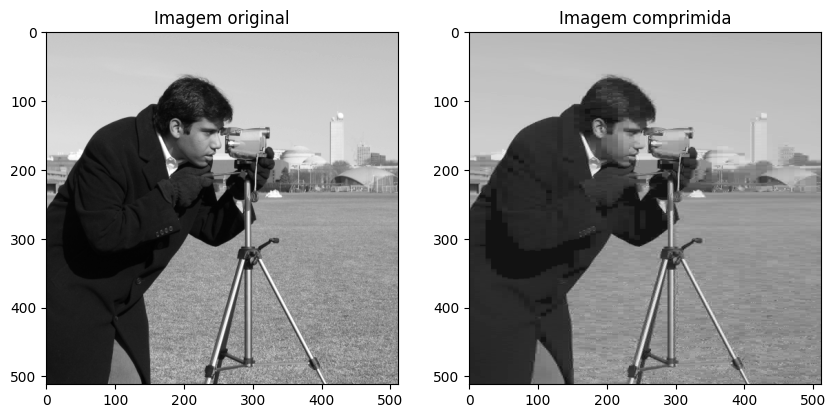

In [565]:
# Plot das duas imagens
fig = plt.figure(figsize=(10, 10))

fig.add_subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Imagem original")
fig.add_subplot(1, 2, 2)
plt.imshow(decompressed_img, cmap='gray')
plt.title("Imagem comprimida")
plt.show()

In [566]:
# #Compute size of compressed image and compression ratio
frac_nonzero = np.sum(np.abs(compressed_img) != 0.0)/compressed_img.size
print("Keeping %.2f%% of DCT coefficients"%(100*frac_nonzero))
print('Taxa de compressão: %.1f:1'%(1/frac_nonzero))

#Compute Peak Signal to Noise Ratio (PSNR)
MSE = np.sum((arr-decompressed_img)**2)/arr.size
PSNR = 10*np.log10(np.max(arr)**2/MSE)
print('MSE: %.2f'%MSE)
print('PSNR: %.2f'%PSNR)

Keeping 15.01% of DCT coefficients
Taxa de compressão: 6.7:1
MSE: 62.47
PSNR: 30.17


In [558]:
# Salvando as imagems
plt.imsave('decompressed_img.png', np.abs(decompressed_img), cmap='gray')
plt.imsave('original.png', img, cmap='gray')

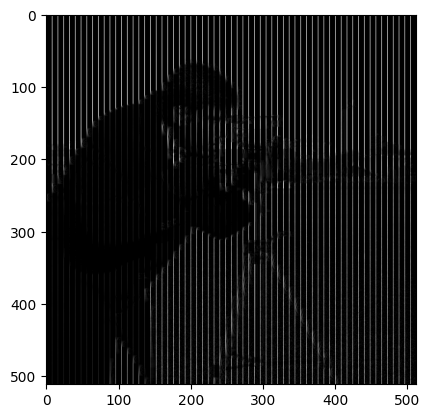

In [527]:
plt.imshow(np.abs(compressed_img), cmap='gray')